In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE  # For handling class imbalance

In [48]:

df = pd.read_csv("/insurance_claims.csv")
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [50]:
df.shape

(1000, 40)

In [51]:
df.drop(columns=['_c39'], inplace=True)

In [52]:
print(df.isnull().sum())

months_as_customer              0
age                             0
policy_number                   0
policy_bind_date                0
policy_state                    0
policy_csl                      0
policy_deductable               0
policy_annual_premium           0
umbrella_limit                  0
insured_zip                     0
insured_sex                     0
insured_education_level         0
insured_occupation              0
insured_hobbies                 0
insured_relationship            0
capital-gains                   0
capital-loss                    0
incident_date                   0
incident_type                   0
collision_type                  0
incident_severity               0
authorities_contacted          91
incident_state                  0
incident_city                   0
incident_location               0
incident_hour_of_the_day        0
number_of_vehicles_involved     0
property_damage                 0
bodily_injuries                 0
witnesses     

In [53]:
df.replace('?', np.nan, inplace=True)

In [54]:
# Fill missing numerical values with median and categorical with mode
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

<ipython-input-54-548504235>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-54-548504235>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [55]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


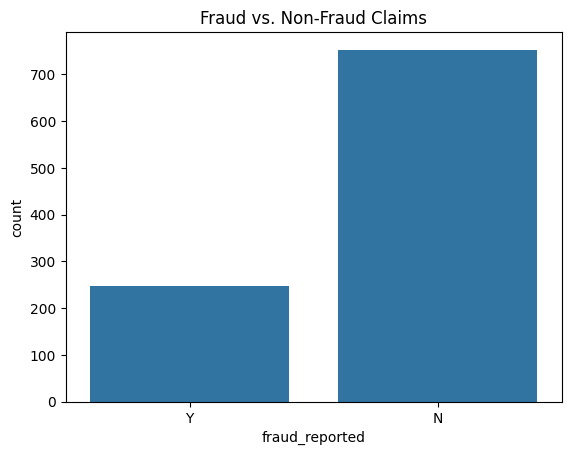

In [56]:
# Plot fraud distribution
sns.countplot(x='fraud_reported', data=df)
plt.title("Fraud vs. Non-Fraud Claims")
plt.show()

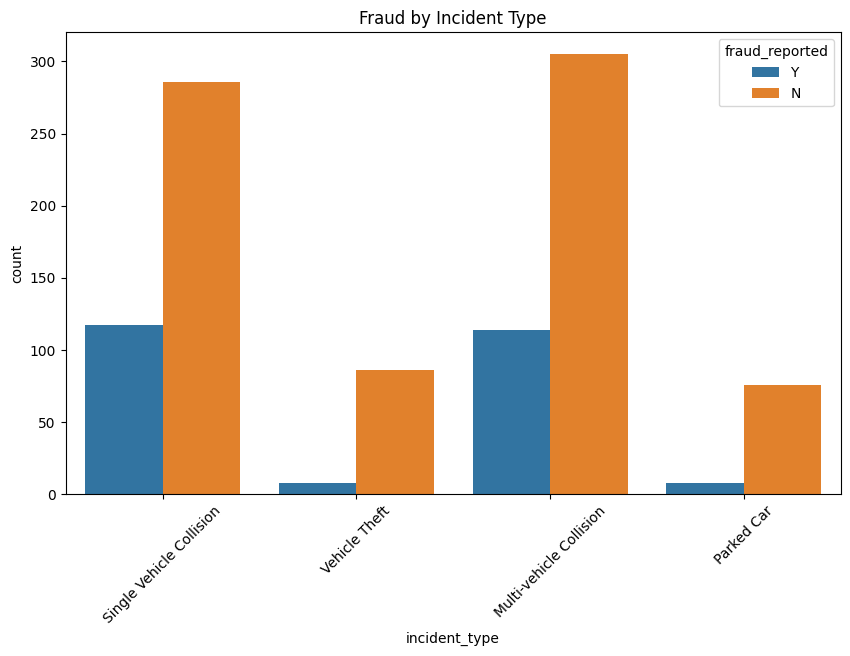

In [57]:
# Analyze fraud by incident type
plt.figure(figsize=(10,6))
sns.countplot(x='incident_type', hue='fraud_reported', data=df)
plt.title("Fraud by Incident Type")
plt.xticks(rotation=45)
plt.show()

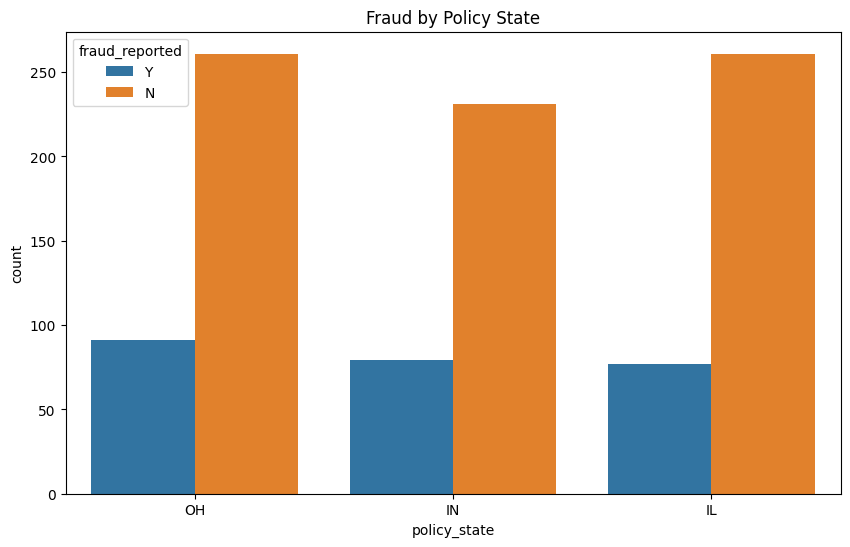

In [58]:
# Analyze fraud by policy state
plt.figure(figsize=(10,6))
sns.countplot(x='policy_state', hue='fraud_reported', data=df)
plt.title("Fraud by Policy State")
plt.show()

In [59]:
# Check correlation of numerical features with fraud
corr = df.corr()['fraud_reported'].sort_values(ascending=False)
print("\nCorrelation with Fraud:")
print(corr)

ValueError: could not convert string to float: '2014-10-17'

In [60]:
# Select categorical columns for encoding
cat_cols = df.select_dtypes(include=['object']).columns.tolist()


In [61]:
# Apply Label Encoding to categorical variables
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [62]:
# Separate features (X) and target (y)
X = df.drop('fraud_reported', axis=1)
y = df['fraud_reported']

In [63]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [65]:
# Scale numerical features (optional, but helps some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [66]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train_smote)

# Predict on test set
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:,1]  # Probabilities for AUC

# Evaluate model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       220
           1       0.59      0.50      0.54        80

    accuracy                           0.77       300
   macro avg       0.71      0.69      0.70       300
weighted avg       0.76      0.77      0.77       300


Confusion Matrix:
[[192  28]
 [ 40  40]]

ROC-AUC Score: 0.7640909090909092


In [67]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

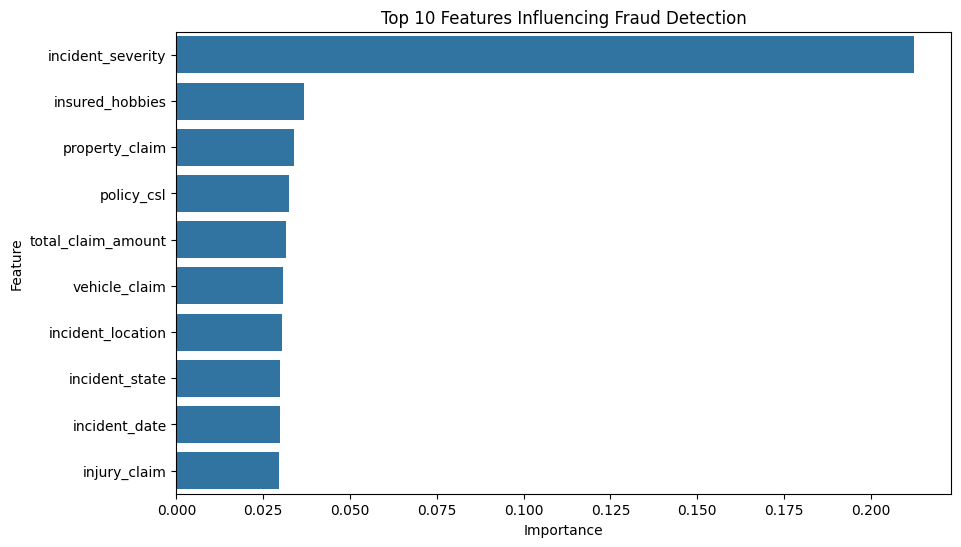

In [68]:
# Plot top 10 important features
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title("Top 10 Features Influencing Fraud Detection")
plt.show()

In [69]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc

In [70]:
## Model Comparison
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train_smote)
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    roc_auc = roc_auc_score(y_test, y_prob)
    results[name] = roc_auc
    print(f"{name}: ROC-AUC = {roc_auc:.4f}")

Random Forest: ROC-AUC = 0.7641
Gradient Boosting: ROC-AUC = 0.8115
AdaBoost: ROC-AUC = 0.7480
SVM: ROC-AUC = 0.6630


In [71]:
## Hyperparameter Tuning for Best Model (Random Forest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=StratifiedKFold(5),
    scoring='roc_auc'
)
grid_search.fit(X_train_scaled, y_train_smote)

print("\nBest Parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)


Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best ROC-AUC: 0.9570135481882739


In [72]:
## Evaluate Tuned Model
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test_scaled)
y_prob_tuned = best_rf.predict_proba(X_test_scaled)[:,1]

print("\nTuned Model Classification Report:")
print(classification_report(y_test, y_pred_tuned))



Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       220
           1       0.60      0.51      0.55        80

    accuracy                           0.78       300
   macro avg       0.72      0.69      0.70       300
weighted avg       0.77      0.78      0.77       300



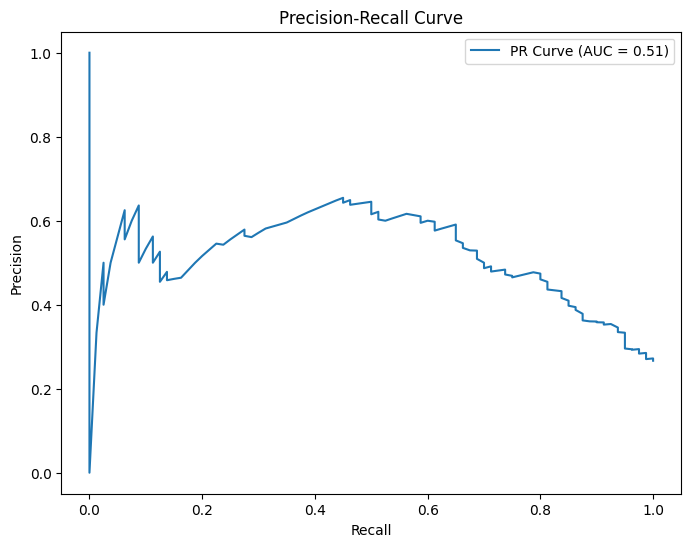

In [73]:
## Precision-Recall Curve (Important for Imbalanced Data)
precision, recall, _ = precision_recall_curve(y_test, y_prob_tuned)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

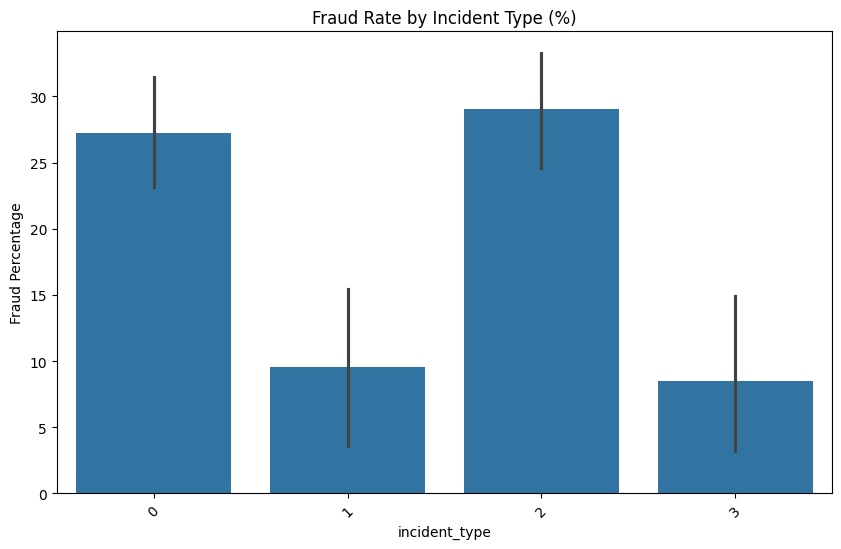

In [74]:
# Fraud by incident type
plt.figure(figsize=(10,6))
sns.barplot(x='incident_type', y='fraud_reported', data=df, estimator=lambda x: sum(x)/len(x)*100)
plt.title("Fraud Rate by Incident Type (%)")
plt.ylabel("Fraud Percentage")
plt.xticks(rotation=45)
plt.show()

<ipython-input-75-2252076288>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['fraud_reported']==1]['age'], label='Fraud', shade=True)
<ipython-input-75-2252076288>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['fraud_reported']==0]['age'], label='Legitimate', shade=True)


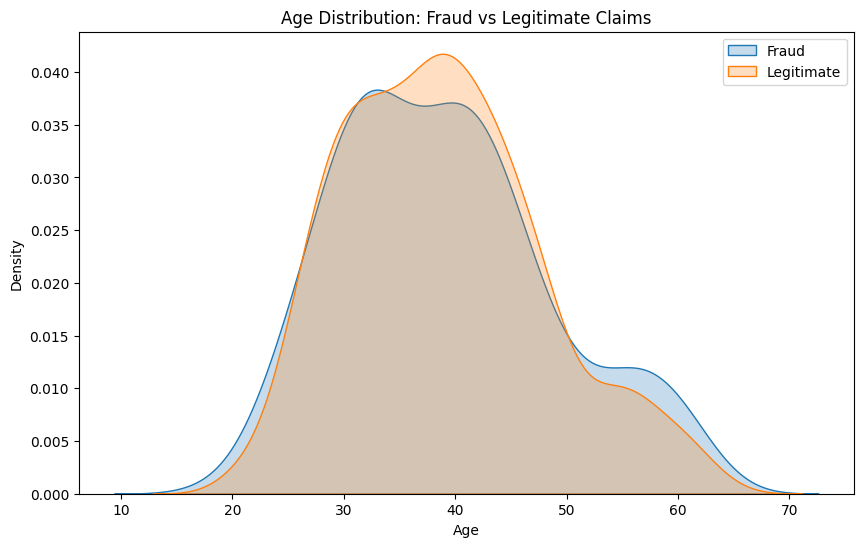

In [75]:
# Age Distribution Comparison
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['fraud_reported']==1]['age'], label='Fraud', shade=True)
sns.kdeplot(df[df['fraud_reported']==0]['age'], label='Legitimate', shade=True)
plt.title("Age Distribution: Fraud vs Legitimate Claims")
plt.xlabel("Age")
plt.legend()
plt.show()

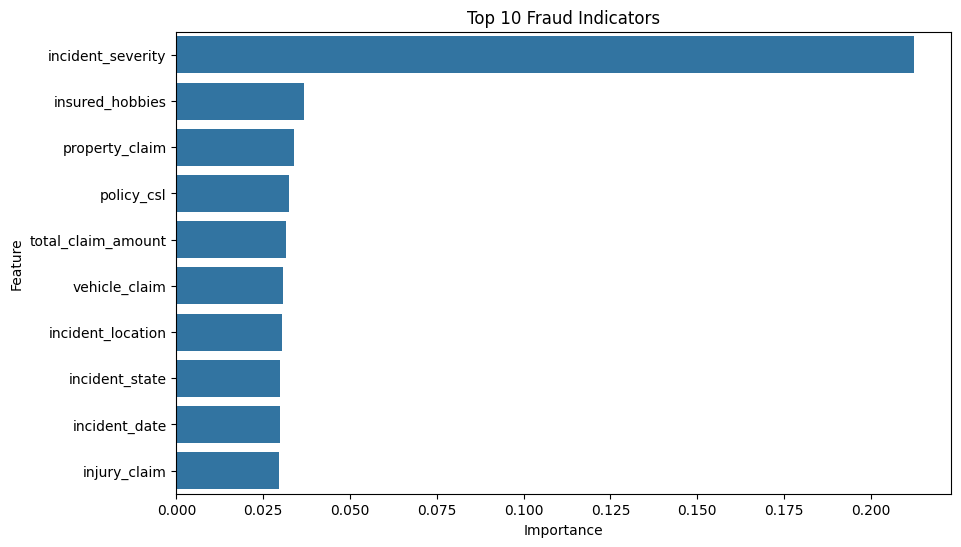

In [76]:
# Feature Importance
top_features = feature_importance.head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title("Top 10 Fraud Indicators")
plt.show()